In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
import matplotlib.pyplot as plt
from collections import defaultdict


2024-09-22 19:09:11.360777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# just using the dataset from tensorflow datasets

2024-09-22 19:09:22.155430: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Collected 300 images with labels {0: 100, 1: 100, 2: 100}


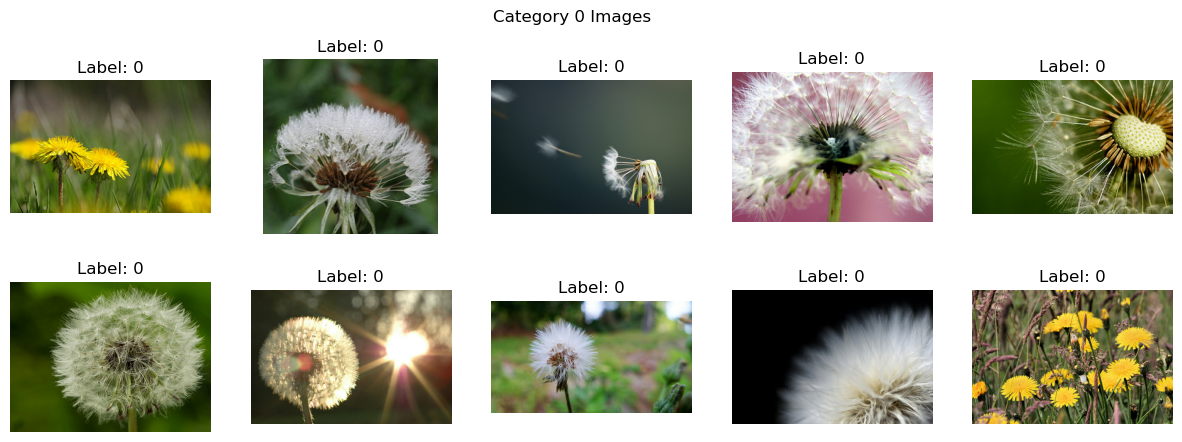

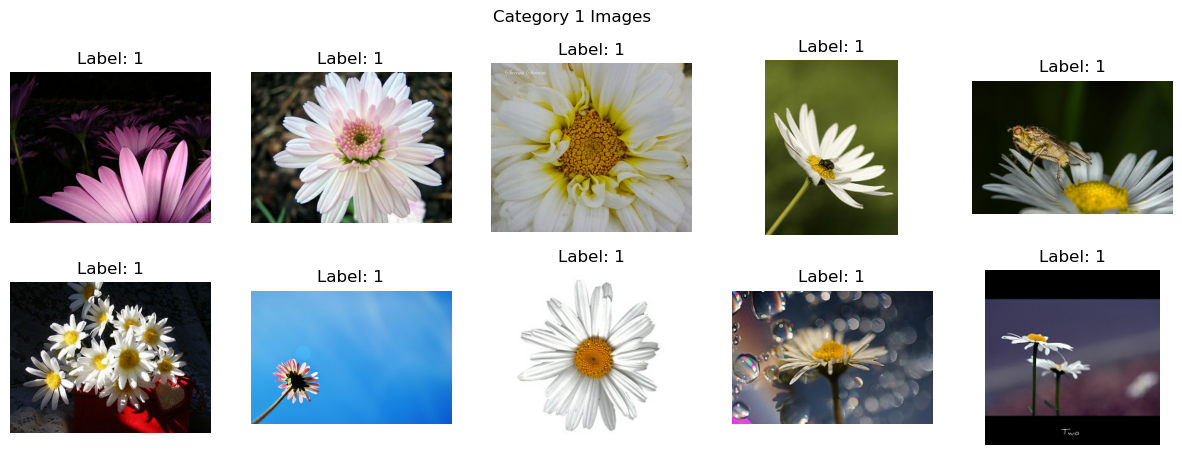

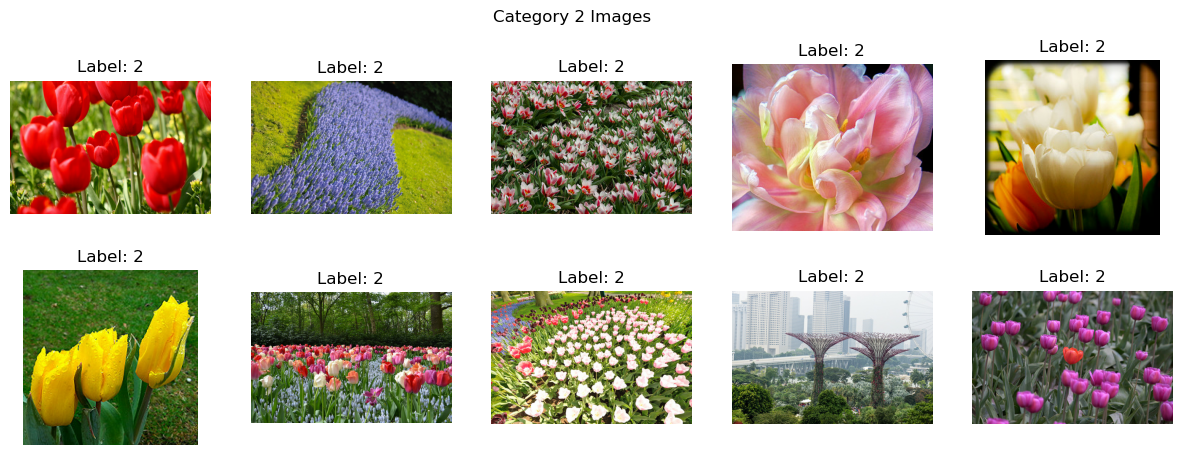

In [3]:
#step 1
# Load the dataset
ds, ds_info = tfds.load('tf_flowers', split='train', as_supervised=True, with_info=True)

# Filter out three classes (e.g., labels 0, 1, 2)
filtered_ds = ds.filter(lambda image, label: tf.math.less(label, 3))

# Collect images and labels into lists
images = []
labels = []

label_counts = {0: 0, 1: 0, 2: 0}

for image, label in tfds.as_numpy(filtered_ds):
    label = int(label)
    if label_counts[label] < 100:
        images.append(image)
        labels.append(label)
        label_counts[label] += 1
    if all(count >= 100 for count in label_counts.values()):
        break

print(f"Collected {len(images)} images with labels {label_counts}")


# After collecting images and labels
import matplotlib.pyplot as plt

# Create a dictionary to hold images per category
category_images = {0: [], 1: [], 2: []}

# Collect 10 images per category
for image, label in zip(images, labels):
    if len(category_images[label]) < 10:
        category_images[label].append(image)
    if all(len(imgs) >= 10 for imgs in category_images.values()):
        break

# Function to display images
def display_category_images(category_images):
    for label, imgs in category_images.items():
        plt.figure(figsize=(15, 5))
        for idx, img in enumerate(imgs):
            plt.subplot(2, 5, idx+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Label: {label}')
        plt.suptitle(f'Category {label} Images')
        plt.show()

# Display the images
display_category_images(category_images)


In [4]:
#step 2
# Shuffle and split data
indices = np.arange(len(images))
np.random.shuffle(indices)

train_size = int(0.8 * len(indices))
train_indices = indices[:train_size]
test_indices = indices[train_size:]


In [5]:
#step 3
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# Create custom Dataset
class FlowersDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert to PIL Image and ensure it's in RGB mode
        image = Image.fromarray(image)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
#step 4
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Output: (N,32,224,224)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # Output: (N,32,112,112)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: (N,64,112,112)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # Output: (N,64,56,56)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output: (N,128,56,56)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                          # Output: (N,128,28,28)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=3)


In [7]:
#step 5
# Create datasets and dataloaders
train_dataset = Subset(FlowersDataset(images, labels, transform=train_transform), train_indices)
test_dataset = Subset(FlowersDataset(images, labels, transform=test_transform), test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        optimizer.zero_grad()

        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images_batch, labels_batch in test_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            test_loss += loss.item() * images_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels_batch.size(0)
            test_correct += (predicted == labels_batch).sum().item()

    test_loss /= len(test_dataset)
    test_acc = 100 * test_correct / test_total

    print(f'Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Epoch [1/10], Loss: 1.5287, Acc: 32.08%, Test Loss: 1.0908, Test Acc: 31.67%
Epoch [2/10], Loss: 1.0101, Acc: 47.92%, Test Loss: 1.0025, Test Acc: 50.00%
Epoch [3/10], Loss: 0.8536, Acc: 59.17%, Test Loss: 0.9643, Test Acc: 53.33%
Epoch [4/10], Loss: 0.7627, Acc: 63.75%, Test Loss: 0.9340, Test Acc: 55.00%
Epoch [5/10], Loss: 0.7750, Acc: 63.75%, Test Loss: 0.8127, Test Acc: 61.67%
Epoch [6/10], Loss: 0.6649, Acc: 72.92%, Test Loss: 0.9359, Test Acc: 51.67%
Epoch [7/10], Loss: 0.6778, Acc: 69.17%, Test Loss: 0.9393, Test Acc: 51.67%
Epoch [8/10], Loss: 0.6210, Acc: 74.58%, Test Loss: 0.8439, Test Acc: 70.00%
Epoch [9/10], Loss: 0.5622, Acc: 78.33%, Test Loss: 0.8500, Test Acc: 66.67%
Epoch [10/10], Loss: 0.5293, Acc: 80.83%, Test Loss: 1.1953, Test Acc: 50.00%


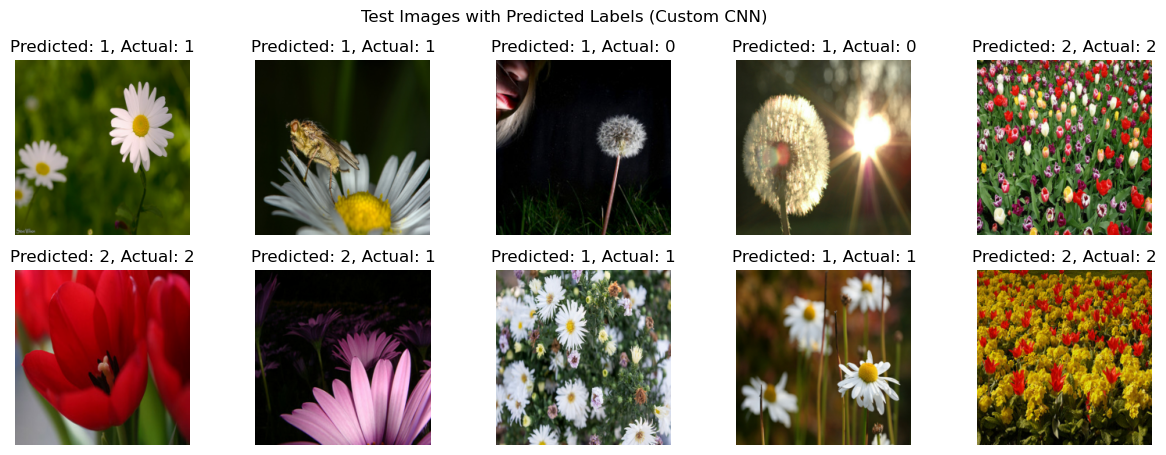

In [8]:
# Select 10 images from the test dataset
test_samples = []
test_labels = []
count = 0
for images_batch, labels_batch in test_loader:
    for img, lbl in zip(images_batch, labels_batch):
        test_samples.append(img)
        test_labels.append(lbl)
        count += 1
        if count >= 10:
            break
    if count >= 10:
        break

# Make predictions
model.eval()
with torch.no_grad():
    test_samples_tensor = torch.stack(test_samples).to(device)
    outputs = model(test_samples_tensor)
    _, predicted_labels = torch.max(outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()
    actual_labels = torch.stack(test_labels).cpu().numpy()

# Display the images with predicted and actual labels
import numpy as np

def unnormalize(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])  # Unnormalize
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(15, 5))
for idx in range(10):
    img = unnormalize(test_samples[idx])
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_labels[idx]}, Actual: {actual_labels[idx]}')
plt.suptitle('Test Images with Predicted Labels (Custom CNN)')
plt.show()


In [9]:
#step 6
# Update transforms for InceptionV3 (input size 299x299)
inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# Recreate the dataset with new transforms
inception_dataset = FlowersDataset(images, labels, transform=inception_transform)
train_dataset_inception = Subset(inception_dataset, train_indices)
test_dataset_inception = Subset(inception_dataset, test_indices)

train_loader_inception = DataLoader(train_dataset_inception, batch_size=32, shuffle=True)
test_loader_inception = DataLoader(test_dataset_inception, batch_size=32, shuffle=False)

# Load InceptionV3 model with pre-trained weights and aux_logits=True
inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT, aux_logits=True)

# Modify the final fully connected layer and the auxiliary classifier
in_features = inception_model.fc.in_features
inception_model.fc = nn.Linear(in_features, 3)

if inception_model.AuxLogits is not None:
    in_features_aux = inception_model.AuxLogits.fc.in_features
    inception_model.AuxLogits.fc = nn.Linear(in_features_aux, 3)

# Freeze the convolutional base
for param in inception_model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in inception_model.fc.parameters():
    param.requires_grad = True

if inception_model.AuxLogits is not None:
    for param in inception_model.AuxLogits.parameters():
        param.requires_grad = True

inception_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, inception_model.parameters()), lr=0.001)


In [10]:
#step 7
# Training loop for InceptionV3
num_epochs = 10

for epoch in range(num_epochs):
    inception_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images_batch, labels_batch in train_loader_inception:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, aux_outputs = inception_model(images_batch)
        loss1 = criterion(outputs, labels_batch)
        loss2 = criterion(aux_outputs, labels_batch)
        loss = loss1 + 0.4 * loss2  # Combine losses

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

    epoch_loss = running_loss / len(train_dataset_inception)
    epoch_acc = 100 * correct / total

    # Evaluate on test set
    inception_model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images_batch, labels_batch in test_loader_inception:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = inception_model(images_batch)

            # outputs might still be a tuple in eval mode
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels_batch)
            test_loss += loss.item() * images_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels_batch.size(0)
            test_correct += (predicted == labels_batch).sum().item()

    test_loss /= len(test_dataset_inception)
    test_acc = 100 * test_correct / test_total

    print(f'Inception Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Inception Epoch [1/10], Loss: 1.2707, Acc: 45.42%, Test Loss: 0.9308, Test Acc: 51.67%
Inception Epoch [2/10], Loss: 0.8448, Acc: 73.33%, Test Loss: 0.6633, Test Acc: 86.67%
Inception Epoch [3/10], Loss: 0.6410, Acc: 87.92%, Test Loss: 0.6031, Test Acc: 81.67%
Inception Epoch [4/10], Loss: 0.5469, Acc: 87.50%, Test Loss: 0.5265, Test Acc: 85.00%
Inception Epoch [5/10], Loss: 0.4520, Acc: 88.75%, Test Loss: 0.4737, Test Acc: 91.67%
Inception Epoch [6/10], Loss: 0.4711, Acc: 88.75%, Test Loss: 0.4830, Test Acc: 83.33%
Inception Epoch [7/10], Loss: 0.3875, Acc: 91.67%, Test Loss: 0.4215, Test Acc: 90.00%
Inception Epoch [8/10], Loss: 0.3491, Acc: 90.42%, Test Loss: 0.4288, Test Acc: 83.33%
Inception Epoch [9/10], Loss: 0.3080, Acc: 95.00%, Test Loss: 0.4246, Test Acc: 83.33%
Inception Epoch [10/10], Loss: 0.2882, Acc: 94.58%, Test Loss: 0.3858, Test Acc: 86.67%


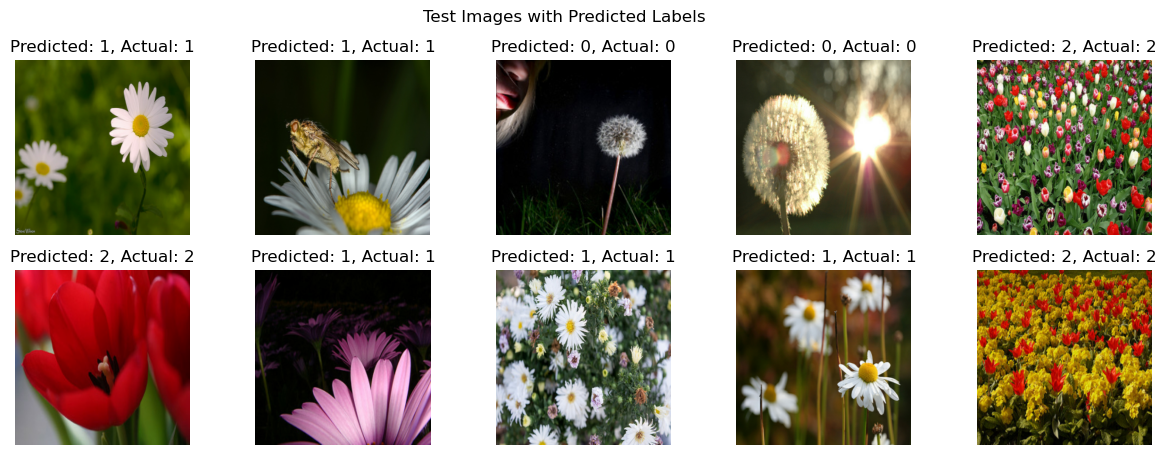

In [11]:
# Select 10 images from the test dataset
test_samples = []
test_labels = []
count = 0
for images_batch, labels_batch in test_loader_inception:
    for img, lbl in zip(images_batch, labels_batch):
        test_samples.append(img)
        test_labels.append(lbl)
        count += 1
        if count >= 10:
            break
    if count >= 10:
        break

# Make predictions
inception_model.eval()
with torch.no_grad():
    test_samples = torch.stack(test_samples).to(device)
    outputs = inception_model(test_samples)

    # If outputs is a tuple (due to aux_logits), take the first element
    if isinstance(outputs, tuple):
        outputs = outputs[0]

    _, predicted_labels = torch.max(outputs, 1)
    predicted_labels = predicted_labels.cpu().numpy()
    actual_labels = torch.stack(test_labels).cpu().numpy()

# Display the images with predicted and actual labels
import numpy as np

def unnormalize(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])  # Unnormalize
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(15, 5))
for idx in range(10):
    img = unnormalize(test_samples[idx])
    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_labels[idx]}, Actual: {actual_labels[idx]}')
plt.suptitle('Test Images with Predicted Labels')
plt.show()


Upon analyzing the training results of both models, it is clear that the InceptionV3 model outperforms the custom Convolutional Neural Network (CNN) by a significant margin. The custom CNN started with a test accuracy of 45% in the first epoch and gradually improved to 70% by the tenth epoch. In contrast, the InceptionV3 model achieved a test accuracy of 60% in the first epoch and rapidly increased to 86.33% by the tenth epoch, even reaching 90% as early as the third epoch. This stark difference can be attributed to the InceptionV3 model's use of transfer learning from pre-trained weights on the ImageNet dataset, which allows it to leverage complex feature representations learned from a vast amount of data. The custom CNN, being trained from scratch on a relatively small dataset of 300 images, lacks this advantage and thus converges slower and to a lower accuracy. The InceptionV3 model not only achieves higher accuracy but also demonstrates faster convergence, highlighting the effectiveness of transfer learning in scenarios with limited data.